## Assignment 1: E-Car
The objective of this assigment is to analize the "e-car data" in order to find a method to improve expected profits

#### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import matplotlib.ticker as mticker
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
#from sckit import optimization

#### Loading the data

In [2]:
d_raw = pd.read_excel('PY_DATA.xlsx', skiprows = 1)
d_raw.sample(5)

,Tier,FICO,Approve_Date,Term,Amount,Previous Rate,Car Type,Competition Rate,Outcome,Rate,Partner
4664,1,780,2003-06-19,36,10500.0,6.87,R,4.39,0,4.39,3
5263,1,731,2003-07-14,36,18300.0,5.99,R,4.39,1,4.39,1
2235,1,722,2004-08-24,36,12275.0,6.00,R,5.05,1,4.75,3
4184,1,801,2004-03-18,36,14000.0,4.50,R,4.45,0,4.45,2
4213,1,768,2004-04-15,36,14800.0,7.48,R,4.45,0,4.45,2


#### Data cleaning and feature engineering

We will drop uninformative fetures that present no variance in the dataset. Those are "Car Type", "Term", and "Tier". Then we split the dataset in training data and test data using sklearn.model_selection. We take 70% 30%(Using a wildy spread rule of thumb). It is true that we should split the data in train, dev and test sets in order to have unbiased test results. Since we do not have enough data to do so we stick with the common train/test separation. Finaly we regularize our imput features.NEW LINE ??

In [3]:
d_raw.drop(columns={'Tier', 'Term','Car Type','Approve_Date'},inplace= True) #DROP DATE sino no puc pillar les interactions

In [4]:
train , test = train_test_split(d_raw, test_size=0.3)
datasets = [train.copy(),test.copy()]
X_train = datasets[0].drop(columns={'Outcome'})
X_test = datasets[1].drop(columns={'Outcome'})
Y_train = datasets[0]['Outcome']
Y_test = datasets[1]['Outcome']
#Generate several copies of the imput features to try different combinations of raw data + augmented data
X_s = [X_train,X_test] #Original
X_s1 = [X_train.copy(),X_test.copy()]
X_s2 = [X_train.copy(),X_test.copy()]
X_s3 = [X_train.copy(),X_test.copy()]
X_s[0].head()

,FICO,Amount,Previous Rate,Competition Rate,Rate,Partner
2334,740,13161.0,6.85,4.75,4.75,1
1231,771,9300.0,8.94,4.75,4.89,3
4401,744,7300.0,7.50,4.39,4.39,1
729,744,15300.0,10.90,4.99,4.99,1
260,766,7067.0,7.50,4.99,4.99,3


#### Feature engineering
For X_s1 we assume that the potential buyer cares about how much it can save (maybe it is not worth to go trough the process of changing your loan if the expected saving is 10$). Moreover we assume that the buyer knows the competition rate and compares the amount saved if he buys to us and the amount saved when he buys to our competitors. Finally we create a dummy that takes value 1 when our rate is the lowest and an interaction between rate and partner.
X_3 will be the one who includes clustering measures to predict outcome. (we will do it later)
In X_2 we simply take all the interaction terms of the raw data
X 3 take all interactions of Xs1 -> we do not care about causality of other variables other than Rate (since we cannot control them) and all Rate interactions could have a reasonable explanation

In [5]:
## GEN DUMMY FOR PARTNER???
#X_s1
for imput_f in X_s1:
    imput_f['Saving_Buy'] = imput_f['Amount']*((imput_f['Previous Rate']-imput_f['Rate'])/100)
    imput_f['Saving_Comp'] = imput_f['Amount']*((imput_f['Previous Rate']-imput_f['Competition Rate'])/100)
    imput_f['Best_rate'] = imput_f['Rate'] < imput_f['Competition Rate'] #and imput_f['Rate'] < ['Previous Rate'])*1
    imput_f['Rate_Partner'] = imput_f['Rate']*imput_f['Partner']
#X_s2
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_s2[0] = poly.fit_transform(X_s[0])
X_s2[1] = poly.fit_transform(X_s[1])
X_s2_labels = poly.fit(X_s[0]).get_feature_names(X_s[0].columns)
X_s2[0] = pd.DataFrame(X_s2[0]) # labels
X_s2[1] = pd.DataFrame(X_s2[1]) #FICAR COL LABEL
#X_s3
X_s3[0] = poly.fit_transform(X_s1[0]) 
X_s3[1] = poly.fit_transform(X_s1[1])
X_s3_labels = poly.fit(X_s1[0]).get_feature_names(X_s1[0].columns)
X_s3[0] = pd.DataFrame(X_s3[0]) #FICAR COL LABEL
X_s3[1] = pd.DataFrame(X_s3[1]) #FICAR COL LABEL

#### Looking at correlations heatmap for X_s

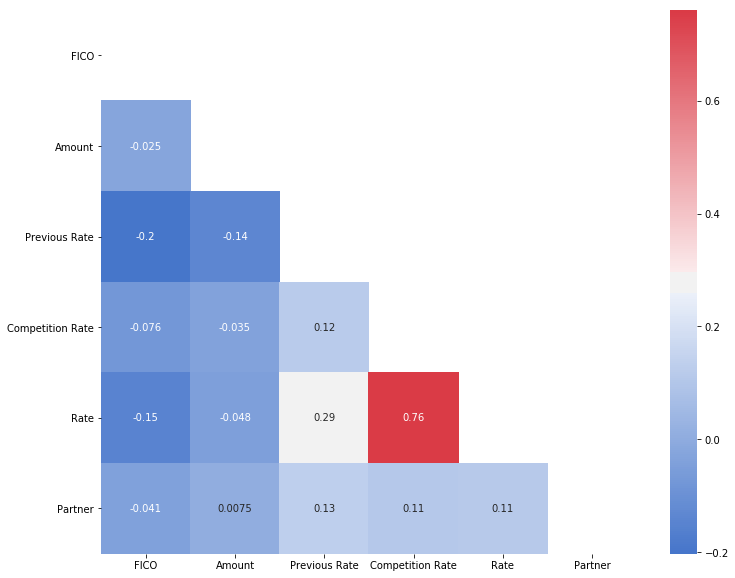

In [6]:
mdata = X_s[0].corr()
mdata = mdata.where(mdata != 1)
mask = np.zeros_like(mdata, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(255,10, as_cmap=True)
fig = plt.figure(figsize=(12,10)) 
#Ficar dataframe de X join Y . ara fico nomes x perque no recordo el comando
hmap = sns.heatmap(mdata,annot=True, mask = mask, cmap=cmap, vmax = mdata.max().max(),vmin = mdata.min().min())
hmap.set_yticklabels(hmap.get_yticklabels(), rotation = 0)
plt.show()#Not needed

#### X regularization

In [7]:
def X_reg(X):
    for label in X.columns:
        MEAN = (X[label] - X[label].mean())
        VAR = (1/X.shape[0])*np.sum(np.power(X[label],2))
        X[label] = MEAN/np.sqrt(VAR)

In [8]:
X_reg(X_s[0])
X_reg(X_s[1])
X_reg(X_s1[0])
X_reg(X_s1[1])
X_reg(X_s2[0])
X_reg(X_s2[1])
X_reg(X_s3[0])
X_reg(X_s3[1])

## Classification models

#### Logit Model

* Maximum likelyhood

In [9]:
def logit_max_in(X,Y):
    B = np.random.randn(X.shape[1],1)*0.001 #(nx,1)
    A = 0
    X = X.T #(nx,m)
    Y = Y.values.reshape(1,4344) #(1,m)
    m = len(Y.T)
    return B , A , X , Y , m
def for_back(X,Y,B,A,m):
    #Linear step
    Z = np.dot(B.T,X)+A #(1,nx)(nx,m) = (1,m)
    #Sigmoid
    S = 1/(1+np.exp(Z)) #(1,m)
    cost = (1/m)*np.sum(-(Y*np.log(S)+(1-Y)*np.log(1-S)))
    #Back
    dZ = Y - S #(1,m)
    dA = (1/m)*np.sum(dZ)
    dB = (1/m)*np.dot(X,dZ.T)
    return dA , dB , cost , S

* Gradient descent

In [10]:
def model(X,Y):
    B, A, X , Y , m = logit_max_in(X,Y)
    costs = []
    for i in range(300000):
        dA , dB, cost , S = for_back(X,Y,B,A,m)
        B = B - 0.01*dB
        A = A - 0.01*dA
        if i % 50000 == 0:
                costs.append(cost)
        if i % 50000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
    return A , B

In [11]:
A , B = model(X_s[0],Y_train)

Cost after iteration 0: 0.693104
Cost after iteration 50000: 0.671123
Cost after iteration 100000: 0.670643
Cost after iteration 150000: 0.670281
Cost after iteration 200000: 0.670007
Cost after iteration 250000: 0.669799


In [12]:
#With sklearn (comprovation)
logisticRegr = LogisticRegression()
model = logisticRegr.fit(X_s[0], Y_train)
sklearnmodel = pd.DataFrame(model.predict_proba(X_s[0]))
def probabilities_pred(X,B,A):
    Z = np.dot(B.T,X.T)+A
    S = 1/(1+np.exp(Z))
    return pd.DataFrame(S)
pred_grad = probabilities_pred(X_s[0],B,A)
sklearnmodel['grad'] = pred_grad.T
sklearnmodel.head()

,0,1,grad
0,0.549517,0.450483,0.450949
1,0.488794,0.511206,0.511800
2,0.433952,0.566048,0.567368
3,0.476236,0.523764,0.524862
4,0.480323,0.519677,0.520394


* To download the data use the following code

In [13]:
# from IPython.display import HTML
# import base64  
# def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
#     csv = df.to_csv()
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)

# create_download_link("DATAFRAME THAT I WANT TO EXPORT)

####  Clustering

* KMeans

* 5 seems to perform well

In [14]:
km_data = d_raw.copy().drop(columns = {'Outcome'})
X_reg(km_data)
X_4_1 = d_raw.copy()
cluster = KMeans(n_clusters=5, random_state =0)
X_4_1['Cluster'] = cluster.fit_predict(km_data)

Split train/test

In [15]:
train4 , test4 = train_test_split(X_4_1, test_size=0.3)
Y_test_k = test4.copy()['Outcome']
Y_train_k = train4.copy()['Outcome']
test_X_k = test4.drop(columns={'Outcome'})
train_X_k = train4.drop(columns={'Outcome'})
X_s4 = [train_X_k.copy(),test_X_k.copy()]

In [16]:
X_reg(X_s4[0])
X_reg(X_s4[1])

* Representation

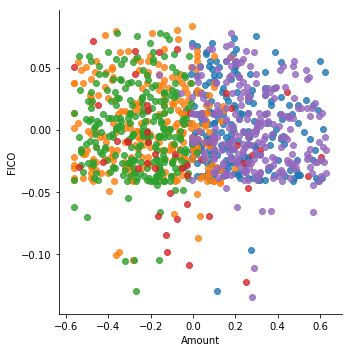

In [17]:
ploting1 = X_s4[0].copy()
model0 = logisticRegr.fit(ploting1, Y_train_k)
probs = pd.DataFrame(model0.predict_proba(ploting1)).drop(columns={0})
ploting1['probs'] = probs
sns.lmplot(x='Amount', y='FICO',data=ploting1.sample(1000),fit_reg=False, hue ='Cluster', legend=False) 

* Hierarchical cluster analysis: AgglomerativeClustering: 10 clusters

In [18]:
km_data = d_raw.copy().drop(columns = {'Outcome'})
X_reg(km_data)
X_5_1 = d_raw.copy()
cluster = AgglomerativeClustering(n_clusters=10)
X_5_1['Cluster'] = cluster.fit_predict(km_data)
cluster_models5 = pd.DataFrame([0])

In [19]:
train5 , test5 = train_test_split(X_5_1, test_size=0.3)
Y_test_a = test5.copy()['Outcome']
Y_train_a = train5.copy()['Outcome']
test_X_k = test5.drop(columns={'Outcome'})
train_X_k = train5.drop(columns={'Outcome'})
X_s5 = [train_X_k.copy(),test_X_k.copy()]

In [20]:
X_reg(X_s5[0])
X_reg(X_s5[1])

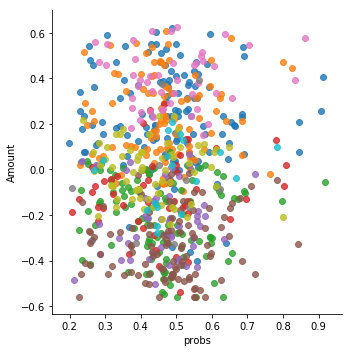

In [21]:
ploting1 = X_s5[0].copy()
model0 = logisticRegr.fit(ploting1, Y_train_a)
probs = pd.DataFrame(model0.predict_proba(ploting1)).drop(columns={0})
ploting1['probs'] = probs
sns.lmplot(x='probs', y='Amount',data=ploting1.sample(1000),fit_reg=False, hue ='Cluster', legend=False) 

#### Models performance (% of correct predictions)
Using sklearn (very similar results to the "hard coded" implementation)

In [22]:
model0 = logisticRegr.fit(X_s[0],Y_train)
print('model  0' + '  ' + str(model0.score(X_s[1],Y_test)))
model1 = logisticRegr.fit(X_s1[0],Y_train)
print('model  1' + '  ' + str(model1.score(X_s1[1],Y_test)))
model2 = logisticRegr.fit(X_s2[0],Y_train)
print('model  2' + '  ' + str(model2.score(X_s2[1],Y_test)))
model3 = logisticRegr.fit(X_s3[0],Y_train)
print('model  3' + '  ' + str(model3.score(X_s3[1],Y_test)))
model4 = logisticRegr.fit(X_s4[0],Y_train_k)
print('model  4' + '  ' + str(model3.score(X_s4[1],Y_test_k)))
model4 = logisticRegr.fit(X_s5[0],Y_train_a)
print('model  5' + '  ' + str(model3.score(X_s5[1],Y_test_a)))

model  0  0.58968850698174
model  1  0.5907626208378088
model  2  0.5907626208378088
model  3  0.6342642320085929
model  4  0.6020408163265306
model  5  0.5767991407089151


#### Distribution of the data (predicted probabilities of the simple model) 

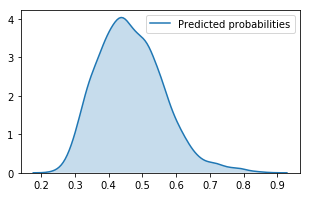

In [23]:
#Predicted probabilities
model0 = logisticRegr.fit(X_s[0], Y_train)
fig =plt.figure(figsize=(5,3))
sns.kdeplot(pd.DataFrame(model0.predict_proba(X_s[0]))[1], shade = True, label = 'Predicted probabilities')

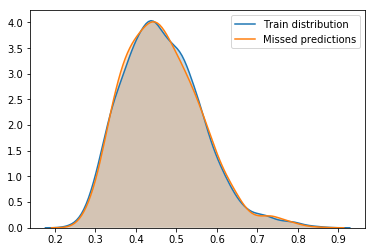

In [24]:
#Predictions vs Wrong predictions dis considering P>0.5 -> =1; 0 otherwise
probas = pd.DataFrame(model0.predict_proba(X_s[0]))
sns.kdeplot(probas[1], shade = True, label = 'Train distribution')
wrong = (model0.predict(X_s[0]) != Y_train)*1
sns.kdeplot(probas[1].where(wrong ==1).dropna(), shade = True, label = 'Missed predictions')

## Profit maximization

#### Single rate for all customers
MAX E(sum(p(buy)price)amount

#### Customized price for every customer

#### Results using the other models

#### Single price for every segment: models 4 and 5

## Summary